# **Testing Set Leakage**

## **Introduction**

### Welcome to the final notebook in the datascience module. You are getting so close and have come so far! This is a notebook demonstrating one of the big DO NOT DOs in machine learning and data science, and we are going to do it here so you can see it, why it is bad, and also learn about some fundamental concepts in machine learning and data science.

### We are going to be covering 'data set leakage'. What this means is that a proportion of your training data gets introduced into your testing set when you making your model, and while this may not seem like a big deal, it is. Some might say, actually, its the biggest deal. So we are going to show you what it looks like when this is happening, and then you will know NEVER to do it again or the overlords of machine learning will come down and smite you forever.
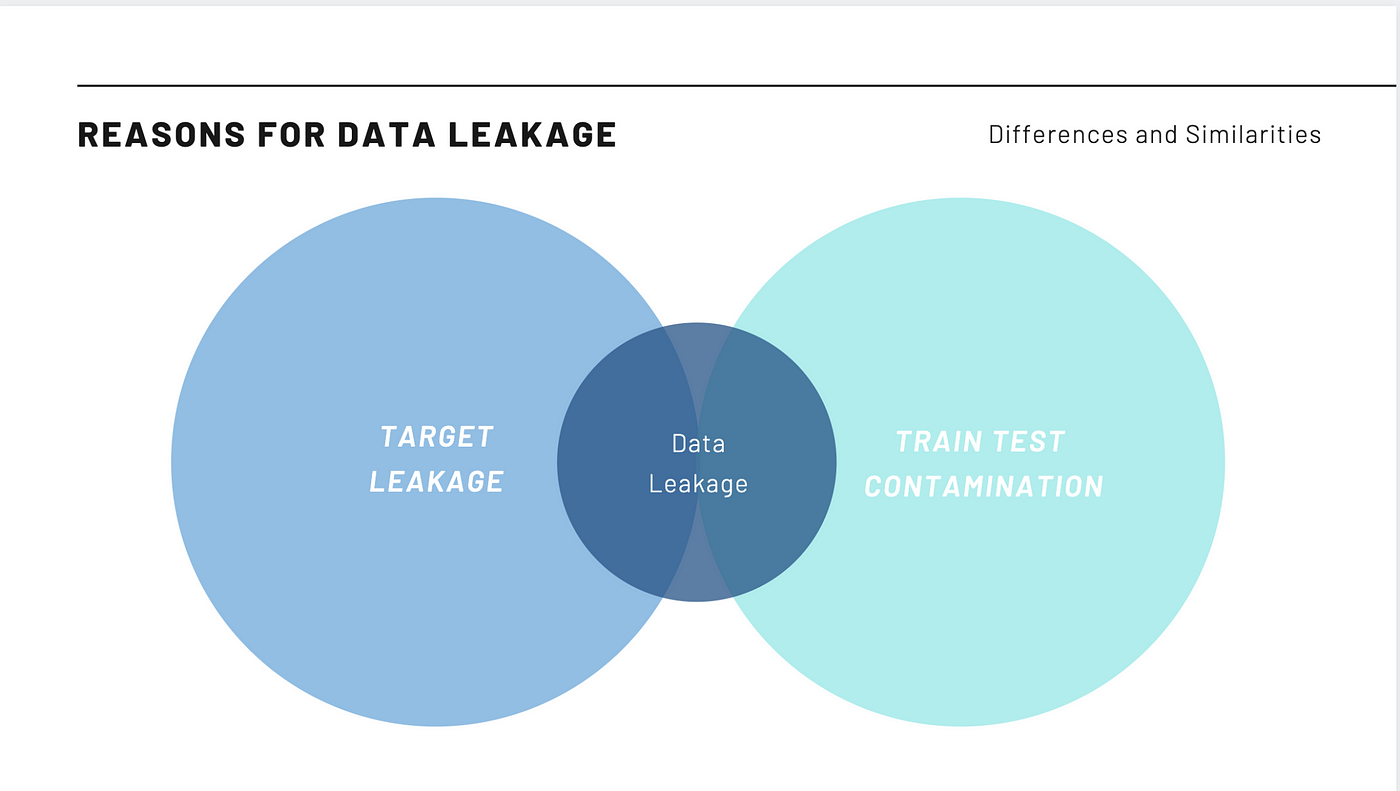
### This will be a relatively short notebook, and we will not really go into a lot of the code written as some of the algorithms have not yet been discussed this far in the course. The point here is to demonstrate what happens when data leakage occurs, how to spot it, and critically how to avoid it!

### Again, just to reiterate, what you are about to see you should never, ever do on purpose!

### **Import Stuff**

In [ ]:
%pip install seaborn
%pip install statsmodels

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  confusion_matrix, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


### Same data preparation code as in the other notebooks. You can skip this- we are just applying the same cleaning and preprocessing we did before in this notebook to get the data in the cleaned state.

In [3]:
df = pd.read_csv('heart_disease.csv')

df.dropna(inplace=True)

categorical_columns = ['Gender', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'Heart_stroke']

for column in categorical_columns:
    df[column] = df[column].astype('category')
        
text_columns = ['Gender', 'education', 'prevalentStroke', 'Heart_stroke']

for column in text_columns: 
    df[column] = df[column].str.lower()
    
df['prevalentStroke'] = df['prevalentStroke'].map({'yes': 1, 'no': 0})
df['Heart_stroke'] = df['Heart_stroke'].map({'yes': 1, 'no': 0})
df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})
df['education'] = df['education'].map({'uneducated': 0, 'primaryschool': 1, 'graduate':2, 'postgraduate':3})

## **Build *Leaky* Function**

### This function is extremely similar to the one used for logistic regressions in the prior notebook, however there are two differences, one you can ignore and one you should pay attention to.

### You can ignore this line `rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced")`. Random Forest is another type of machine learning algorithm (as oppposed to logistic regression) that will be covered in the next module, and we used it here because the negative side effects of data leakage are more pronounced. Don't worry about why as you can piece that together through self study or continuation in the course, but that is why we are using it here!

### THe change you *should* pay attention to is where it says "Induce data leakage..." This is where the we add on a percentage of the testing data (how much is determined by the argument `leakage_proportion`) and concatenate it to the training data. We will manipulate this percent later on!

In [89]:

def randomForest(x, y, num_features, leakage_proportion=0.0):
    # Split the input data
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Induce data leakage: leak a proportion of the test data into the training data
    # Calculate the number of test data points that will be leaked into the training set.
    # This is based on the leakage proportion and the size of the test set.
    leak_size = int(leakage_proportion * X_test.shape[0]) 

    # Add the first 'leak_size' number of rows from X_test to X_train.
    # pd.concat() is a pandas method to concatenate two dataframes along a particular axis (default axis=0, which is rows).
    X_train = pd.concat([X_train, X_test[:leak_size]]) 

    # Similarly, add the first 'leak_size' number of rows from y_test to y_train.
    y_train = pd.concat([y_train, y_test[:leak_size]])

    # Standardize the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced")

    # RFE
    selector = RFE(rf_model, n_features_to_select=num_features, step=1)
    selector = selector.fit(X_train_scaled, y_train)
    
    # Get selected features
    selected_features = pd.Series(selector.support_, index=X_train.columns)

    # Transform the training and test data using only the selected features
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)

    # Fit and predict
    rf_model.fit(X_train_selected, y_train)
    y_pred = rf_model.predict(X_test_selected)
    
    # Metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    y_pred_proba = rf_model.predict_proba(X_test_selected)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return classification_report(y_test, y_pred), conf_matrix, roc_auc




## **Prepare DF**

### Here we are just preparing the dataframe to fit the model with. We start by doing one hot encoding via `pd.get_dummies(df)` like previously, and then we select a sample of the data (20%) to move forward with via `sample_df = df_encoded.sample(frac=0.2, random_state=42)`. The reasons we do this are trying to magnify the effects of data leakage, and they are more pronounced with smaller data sets. Why will become clear in a bit, but feel free to ponder this now!

In [90]:
## Reducing the dataset size
df_encoded = pd.get_dummies(df)
sample_df = df_encoded.sample(frac=0.2, random_state=42)
x_sample = sample_df.drop(columns=['Heart_stroke'])
y_sample = sample_df['Heart_stroke']

## **Train and Test *Leaky* Model**
### Now we are going to send the data to the logistic regression function. Remember we have added a new argument to pass to the `randomForest` function, which is the the percentage of data we want to leak. Lets start with 0 leakage to see what happens when the train and test sets are truly independent


In [91]:
classification_report_output, conf_matrix, roc_auc = randomForest(x_sample, y_sample, 7, 0.0)

print('Classification Report \n', classification_report_output)
print('Confusion Matrix \n', conf_matrix)
print('ROC-AUC \n', roc_auc)

Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.97      0.86       114
           1       0.25      0.03      0.05        33

    accuracy                           0.76       147
   macro avg       0.51      0.50      0.46       147
weighted avg       0.66      0.76      0.68       147

Confusion Matrix 
 [[111   3]
 [ 32   1]]
ROC-AUC 
 0.6967038809144073


### Alright so this our baseline. This is the model making predictions when the train and test data are completely separated from each other. It identified heart 3% of the heart stroke patients (recall) and when it predicted heart stroke it was correct 25% of the time (precision). This model would forsure neeed finetuning and more work to complete, but that is not our goal here.

### Now lets leak 10% of the data from the train set into the test set and see what happens. All we changed here is the last argument in the `randomForest` call.

In [98]:
classification_report_output, conf_matrix, roc_auc = randomForest(x_scaled_df, y, 7, 0.1)

print('Classification Report \n', classification_report_output)
print('Confusion Matrix \n', conf_matrix)
print('ROC-AUC \n', roc_auc)

Classification Report 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92       610
           1       0.87      0.11      0.19       122

    accuracy                           0.85       732
   macro avg       0.86      0.55      0.55       732
weighted avg       0.85      0.85      0.80       732

Confusion Matrix 
 [[608   2]
 [109  13]]
ROC-AUC 
 0.6864686912120398


### For doing nothing, we got a pretty sizeable change here. Now when it predictes heart stroke it is right 87% of the time (precision), and it correctly got right 11% of the heart stroke individuals in the dataset (recall)

### Lets bump the leakage up to 50% now

In [99]:
classification_report_output, conf_matrix, roc_auc = randomForest(x_scaled_df, y, 7, 0.5)

print('Classification Report \n', classification_report_output)
print('Confusion Matrix \n', conf_matrix)
print('ROC-AUC \n', roc_auc)

Classification Report 
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       610
           1       1.00      0.46      0.63       122

    accuracy                           0.91       732
   macro avg       0.95      0.73      0.79       732
weighted avg       0.92      0.91      0.90       732

Confusion Matrix 
 [[610   0]
 [ 66  56]]
ROC-AUC 
 0.8647675356087072


### OK now we are seeing a trend. Now when it predictes heart stroke it is right 100% of the time (precision), and it correctly got right 46% of the heart stroke individuals in the dataset (recall)

### Lets do one full send and leak 90% of the testing data into the training set

In [101]:

classification_report_output, conf_matrix, roc_auc = randomForest(x_scaled_df, y, 7, 0.9)

print('Classification Report \n', classification_report_output)
print('Confusion Matrix \n', conf_matrix)
print('ROC-AUC \n', roc_auc)

Classification Report 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       610
           1       1.00      0.90      0.95       122

    accuracy                           0.98       732
   macro avg       0.99      0.95      0.97       732
weighted avg       0.98      0.98      0.98       732

Confusion Matrix 
 [[610   0]
 [ 12 110]]
ROC-AUC 
 0.969866971244289


### Are you starting to see why this is a problem now? If we didn't know we had leaked any data, we would look at this and say that we built an almost perfect classifer (ROC-AUC of .97, precision and recall off the charts). With 90% leakage, it only made 12 mistakes when being tested.

### So why is this? You might have an intuitive idea, but consider that you were taking a test and someone gave you 10% of all of the answers to study. Well you are going to certainly do a lot better than someone that had to study totally from the textbook, but you are definitely going to do a lot worse than the person who was given 90% of the test to study from. 

### That is almost exactly what is going on here. When we leaked data, we allowed our model to 'cheat' during training. Because it had already 'seen' the data it was being tested on, as we leaked more and more data our model evaluation metrics kept going up. This is a huge problem in the real world, as we don't do computer science to cheat, we build them to solve problems that can help improve patient care. If you make predictions based on a faulty model, you are essentially using random noise in scenarios that have real world outcomes- not a  good thing

### The technical term for what this means is called `overfitting`. We have fit our model so well to the test data that it performed exceptionally well on the test data. However, when presented with new, unseen data (outside of the training and test set), the model's performance can drop significantly. It has become too tailored or "overfit" to the specific quirks and patterns in the training and leaked data, and thus, it may not generalize well to new data. We saw an improvment in the model's ability on the test set (because we leaked the data), but if your model is overfitting from too much training or another reason the hallmark is a good performance during training followed by a poor performance on your test set. 

### In contrast, underfitting occurs when a model is too simplistic and fails to capture the underlying patterns in the data, leading to poor performance both on training and test data. Very simple models such as linear regression on non-linear data are prone to underfitting.,

### This balance between overfitting and underfitting is influenced by `bias` and `variance`. `Bias` refers to the error introduced by approximating a real-world problem, which may be complex, by a too-simple model. High bias can lead to underfitting. On the other hand, `variance` measures how much the model's predictions would change if trained with a different training dataset. High variance can result in overfitting, as the model becomes too tailored to the training data and loses its ability to generalize.

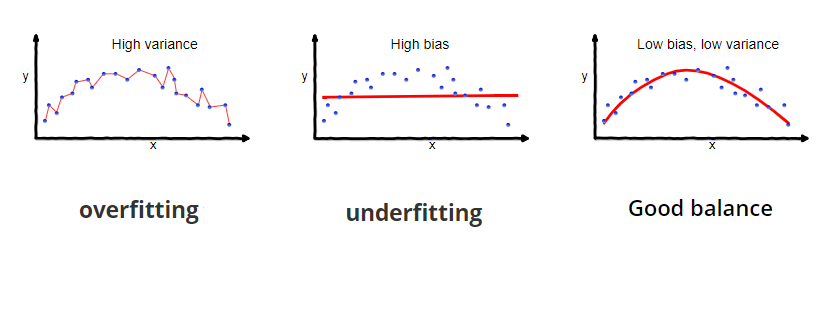

### These are the fundamental concepts that underlie all of data science and artificial intelligence research, and knowing them well (and how to recognize them in practice) will be crucial to your sucess when you embark on your own data science journey. That is all for the data scienc module! Great job on making it through, and we will see you in the next module, Advanced Data Science!
